In [1]:
#!pip install bert_score

## Comment classification by converting it to a se2seq problem
We are treating as a Label generation problem. The Label will be generated by the decoder. Encoder will encode the comment text. The idea was explored to see if the attention will add any accuracy to the classifications.



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline
import pandas as pd

In [3]:
##define the maximum length of the comment
MAX_LENGTH = 100

## Create the dataset


In [6]:
commentDF = pd.read_csv('data/comments_all.csv')
commentDF=commentDF[['commentText','commentClassification']]
commentDF=commentDF[commentDF['commentClassification'].isin(['BUGGYCODE_SUGGESTION','REFACTORING_SUGGESTION','CODE_SUGGESTION','QUESTIONING',
                    'COMPLETENESS_SUGGESTION','LOGISTICS_SUGGESTION','LOGICAL_SUGGESTION','SPELLING_SUGGESTION',
                     'REUSE_SUGGESTION','DOCUMENTATION_SUGGESTION'])]
commentDF=commentDF.reset_index()
commentDF.commentClassification.value_counts()
commentDF.shape

(4764, 3)

In [91]:
commentDF

,commentText,commentClassification
0,Please remove it and folder `PaymentsOld` comp...,CODE_SUGGESTION
1,"Are we are not using these strings? then, plea...",REFACTORING_SUGGESTION
2,Call `:paymentId` as `:warehouseId` so that it...,SPELLING_SUGGESTION
3,"No need to make it caps, Button by default sho...",CODE_SUGGESTION
4,Follow `No pending invoices` instead of `No Pe...,SPELLING_SUGGESTION
...,...,...
4855,There is issue in this query with single quote.,BUGGYCODE_SUGGESTION
4856,Needs to be \n` 'ALTER TABLE invoicetemplatem...,CODE_SUGGESTION
4857,Please swap the logic and use isset here. \nw...,BUGGYCODE_SUGGESTION
4858,Please make it re-runable.\n\n‌,BUGGYCODE_SUGGESTION


## utility functions

In [92]:
## function to remove the urls from the comments if any
def removeURLs(text):
    URLless_string=text
    try:
        URLless_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
        print("removed url")
    except:
        print("some error")
    return URLless_string

In [93]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    try:
        s = unicodeToAscii(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
        s=s.replace('\n','')
        s=s.replace('\r','')
        s=s.replace('\t','')
    except:
        print("issues",s)
    return s

In [94]:
def getDeciles(df,column):
    res=pd.DataFrame(df[column].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])).reset_index()
    res.columns=['quantile','limit']
    return res 

## Update the dataframe 

In [95]:
## apply the preprocessing
commentDF['commentText']=commentDF['commentText'].apply(lambda x:removeURLs(x))
commentDF['commentText']=commentDF['commentText'].apply(normalizeString)
commentDF['commentClassification']=commentDF.commentClassification.apply(normalizeString)
commentDF

removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
remo

removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
removed url
remo

,commentText,commentClassification
0,please remove it and folder paymentsold comple...,code suggestion
1,are we are not using these strings ? then plea...,refactoring suggestion
2,call paymentid as warehouseid so that it s cle...,spelling suggestion
3,no need to make it caps button by default show...,code suggestion
4,follow no pending invoices instead of no pendi...,spelling suggestion
...,...,...
4855,there is issue in this query with single quote .,buggycode suggestion
4856,needs to be alter table invoicetemplatemapping...,code suggestion
4857,please swap the logic and use isset here . wil...,buggycode suggestion
4858,please make it re runable .,buggycode suggestion


In [96]:
## save the DF to a csv file. This will be used to convert it into the seq2seq form
# trainDF.to_csv("data/commentsPairsTrain.txt",sep="\t",index=False)
# testDF.to_csv("data/commentsPairsTest.txt",sep="\t",index=False)

# commentDF=trainDF
commentDF.to_csv("data/commentsPairs.txt",sep="\t",index=False)


In [97]:
### check what is the general length of the comments..this will help in determining 
### if the max length choice is good or bad
commentDF['stats']=commentDF['commentText'].str.split().apply(len)
getDeciles(commentDF,'stats')

,quantile,limit
0,0.10,3.00
1,0.20,5.00
2,0.30,6.00
3,0.40,8.00
4,0.50,10.00
5,0.60,13.00
6,0.70,16.00
7,0.80,21.00
8,0.90,29.00
9,0.99,69.37


### Dataset preparation code .

We will convert the code to a language transaltion format ..where the comments text is lang1 and the labels is lang2
The task is then to generate the lang2 given the lang1


In [98]:
SOS_token = 0
EOS_token = 1

## the class will store the vocabulary in both word->index and index->word format
## also we have added special SOS and EOS characters to mark the start and end of the sentences
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [99]:
## the function will create teh vocabulary for both the comments and the labels.. Also it will create the pairs
def readLangs(lang1, lang2, fileName, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(fileName, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances for each part of the pair
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [100]:
## this will make sure that we have only MAX_LENGHT string
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [101]:
def prepareData(lang1, lang2,fileName, reverse=False):
    #get the pairs and the two langugae instances
    input_lang, output_lang, pairs = readLangs(lang1, lang2,fileName, reverse)
    
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    
    ## for each of the pairs we need to add it as a sentence and hence the tokens to the vocabulary
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs



In [102]:
#pd.read_csv('data/commentsPairs.txt',sep="\t")

In [103]:
input_lang, output_lang, pairs = prepareData('comment', 'label','data/commentsPairs.txt', False)
#input_lang_test, output_lang_test,testing_pairs = prepareData('comment', 'label','data/commentsPairsTest.txt', False)

print(random.choice(pairs))

Reading lines...
Read 4765 sentence pairs
Trimmed to 4752 sentence pairs
Counting words...
Counted words:
comment 4396
label 14
['why we have commented this ?', 'questioning']


In [104]:
## check the labels
input_lang.word2index
   

{'commenttext': 2,
 'please': 3,
 'remove': 4,
 'it': 5,
 'and': 6,
 'folder': 7,
 'paymentsold': 8,
 'completely': 9,
 '.': 10,
 'we': 11,
 'can': 12,
 'create': 13,
 'mock': 14,
 'in': 15,
 'all': 16,
 'new': 17,
 'apis': 18,
 'payments': 19,
 'itself': 20,
 'are': 21,
 'not': 22,
 'using': 23,
 'these': 24,
 'strings': 25,
 '?': 26,
 'then': 27,
 'removed': 28,
 'changes': 29,
 'call': 30,
 'paymentid': 31,
 'as': 32,
 'warehouseid': 33,
 'so': 34,
 'that': 35,
 's': 36,
 'clear': 37,
 'showing': 38,
 'payment': 39,
 'warehouse': 40,
 'wise': 41,
 'no': 42,
 'need': 43,
 'to': 44,
 'make': 45,
 'caps': 46,
 'button': 47,
 'by': 48,
 'default': 49,
 'shows': 50,
 'spaces': 51,
 'export': 52,
 'const': 53,
 'proceed': 54,
 'pay': 55,
 'trans': 56,
 'follow': 57,
 'pending': 58,
 'invoices': 59,
 'instead': 60,
 'of': 61,
 'i': 62,
 'have': 63,
 'tried': 64,
 'for': 65,
 'flow': 66,
 'this': 67,
 'most': 68,
 'the': 69,
 'places': 70,
 'key': 71,
 'nav': 72,
 'links': 73,
 'thinks': 74

In [105]:
commentDF['commentClassification'].value_counts()*.20

buggycode suggestion        197.6
refactoring suggestion      185.0
code suggestion             181.2
questioning                 109.0
completeness suggestion      83.4
logistics suggestion         70.0
logical suggestion           63.2
spelling suggestion          43.4
reuse suggestion             12.8
documentation suggestion      7.2
Name: commentClassification, dtype: float64

## Splitting the data into test and training set
Basically we first created the vocabulary
Then we are using the train_test cplit to create the training and test DF
finally the df are converted to the pairs as it is required in the seq2seq network

In [106]:
from sklearn.model_selection import train_test_split

# save features and targets from the 'iris'
features, targets = commentDF.commentText.values, commentDF.commentClassification.values

# both train_size and test_size are defined when we do not want to
# use all the data for training and testing e.g. in below example we can
# use train_size=0.4 and test_size=0.2
train_features, test_features, train_targets, test_targets = train_test_split(
        features, targets,
        train_size=0.8,
        test_size=0.2,
        # random but same for all run, also accurancy depends on the
        # selection of data e.g. if we put 10 then accuracy will be 1.0
        # in this example
        random_state=23,
        # keep same proportion of 'target' in test and target data
        stratify=targets
    )

In [110]:
trainDF=pd.DataFrame()
trainDF['commentText']=list(train_features)
trainDF['commentClassification']=list(train_targets)
trainDF['length'] = trainDF.commentText.str.len()
trainDF=trainDF[trainDF['length']<100]
trainDF.to_csv('attentionTrain.csv')

In [111]:
testDF=pd.DataFrame()
testDF['commentText']=list(test_features)
testDF['commentClassification']=list(test_targets)
testDF['length'] = testDF.commentText.str.len()
testDF=testDF[testDF['length']<100]
testDF.to_csv('attentionTest.csv')
testDF['commentClassification'].value_counts()

refactoring suggestion      168
buggycode suggestion        136
code suggestion             124
questioning                  91
completeness suggestion      67
logistics suggestion         65
spelling suggestion          33
logical suggestion           31
reuse suggestion              9
documentation suggestion      6
Name: commentClassification, dtype: int64

In [78]:
## make sure that we are removing all the comments that are larger than the MAX length
testPairs=[]
for i in range(testDF.shape[0]):
    if(len(testDF.iloc[i]['commentText'].split(' ')) < MAX_LENGTH):
        testPairs.append([testDF.iloc[i]['commentText'],testDF.iloc[i]['commentClassification']])
    
#testPairs

trainPairs=[]
for i in range(trainDF.shape[0]):
    if(len(trainDF.iloc[i]['commentText'].split(' ')) < MAX_LENGTH):
        trainPairs.append([trainDF.iloc[i]['commentText'],trainDF.iloc[i]['commentClassification']])
    

## Encoder Class
It follows are basic architecture of Input Tensor >> Emebedding Layer >> GRU

Refer to the diagram 
![image](img/encoder.png)


In [25]:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention Mechanism

This is the main class that defines the attention mechanism along with the decoder part

The attention has been calculated little differently than the usual method (Additive Attention). 

I will explain both the ways

1. Attention architecture as used in the code:
![image](img/attention_architecture_example.png)



Following is the approach

1. Calculate the attention weights which is set of $\alpha$s. We make use of $D_t\__1$ which is the previous hidden state and the input at time t which is same as Output of the previous state. we denote it as $O_t\__1$ 
so Attention weight is a function of  $D_t\__1$ & $O_t\__1$ 

2. Now $D_t\__1$ & $O_t\__1$  is passed to a FC to get a set of paramters that can be trained in order to find the real values of set of $\alpha$ => $\{α_1,\alpha_2....\alpha_N\} $

![image](img/attention_weights1.png)


3. The attention weights are then applied to the Encoded_Outputs which is essentially all the hidden states of the Encoder so that we can now choose which all Encoder outputs are going to affect the Decoder most. The attention is essentially a set of weights to pick up the right percentage of the Encoder_outputs

  $\alpha . E_o $.. this is esentially equal to $\alpha_1 * E_1 + \alpha_2*E_2 +....\alpha_N* E_N $

  the above step is also called the __attention applied__ and is performed by a special function called __BMM__.  $\alpha . E_o $ is also called the __Context Vector__

4. Now we have the weighted effect of Encoder outputs ready . So we combine it with the input of the decoder which is $O_t\__1$
So basically $[O_t\__1,\alpha.E_o]$
This step is also called the __attention_combined__

5. The __attention_combined__ is sent to the GRU and the output & hidded i.e. $O_t$ & $D_t$ for the state t are obtained

Now the __biggest concern__ is the attention step which is step2. Why are hidden state combined with the input. They will be almost the same . The idea is to check the effect of Encoder states on the decoder states and so attention should be calculated using Encoder outputs rather than the Decoder Output



### Alternate approach. (additive Attention)

The main difference is the paramters that are used to create the attention weights

The attention is calculated using the $D_t\__1$ and Encoder_Outputs ($E_o$)

So the attention block will look like the following
![image](img/attention_weights2.png)


And then the Set of alphas are combined with the Encoder_outputs to get the __Context Vector__ or what was called earlier as __attention_applied__ done using __bmm__

Other steps remains more or less similar

The major advantage is that the alphas are learnt after the interaction between the decoder and the Encoder which is what we wanted that decoder should find out how much different Encoder Outputs are required for the new prediction
The following is the complete architecture

![image](img/attention_calculation_Additive.png)




In [26]:
class AdditiveAttention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim):
        super(AdditiveAttention,self).__init__()
        self.decoder_dim=decoder_dim #256 this is the dimention of the D(t-1)
        self.encoder_dim=encoder_dim ## the diemtion of each outut of the encoder...this in our case is 256 
        self.W_Combined = torch.nn.Parameter(
            torch.FloatTensor(self.decoder_dim).uniform_(-0.1, 0.1)) ## this is one of the weight matrix that will be sed to combine the weitghs
        
        self.W_Decoder = torch.nn.Linear(decoder_dim, decoder_dim)# adding weight to the decoder
        self.W_EncoderOutput = torch.nn.Linear(encoder_dim, decoder_dim) ## this will convert the encoder to decoeer dimention

    def get_weights(self,        
        query: torch.Tensor,  # query = decoder hidden
        values: torch.Tensor,  # encoder output of the form maxLength*encoder_dim in ou r case it is 10x256
    ):
#         query = query.repeat(values.size(0), 1)  # [seq_length, decoder_dim]..we need to add the query to each value of encoder
        ##query is 1x256 and ecoder is 10x 256 to add there will be implicit broadcasting
        attn_weights = self.W_Decoder(query) + self.W_EncoderOutput(values)  # [seq_length, decoder_dim]
        return F.softmax((torch.tanh(attn_weights) @ self.W_Combined),dim=1) # [seq_length]

In [27]:
import numpy as np
class MultiplicativeAttention(nn.Module):

    def __init__(self, encoder_dim: int, decoder_dim: int):
        super(MultiplicativeAttention,self).__init__()
        self.decoder_dim=decoder_dim
        self.encoder_dim=encoder_dim
        self.W = torch.nn.Parameter(torch.FloatTensor(
            self.decoder_dim, self.encoder_dim).uniform_(-0.1, 0.1))

    def get_weights(self,
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
    ):
        weights = query @ self.W @ values.T  # [seq_length]
        return F.softmax((weights/np.sqrt(self.decoder_dim)),dim=1)  # [seq_length]

## Decoder making use of the Attention

In [28]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
       
        ## making use of the multiplicative attention
        self.attention = MultiplicativeAttention(256,256)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights=self.attention.get_weights(hidden[0],encoder_outputs)

        
        ##all this is generic
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [29]:
def indexesFromSentence(lang, sentence):
    listWords=[]
    for word in sentence.split(' '):
        try:
            listWords.append(lang.word2index[word])
        except:
            print("cc--",word)
    return listWords


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#### we are making use of the Teacher Forcing which is a way of sending the actual ground truth while the trainign is going on

In [30]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    ##encode the input
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    ##initialize decoder and proceed
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #print("train:",decoder_output,target_tensor[di])
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#### utility function for capturing the time of  execution

In [31]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

## METRICS


Function to calculate the **BERT Score**. We are using the bert_score library to do so
The function will take as input the encoder and decoder objects and generate the F1 score on the basis of the Precision and Recall

The BERTScore is essentially doing the validation of the model that has been trained so far. That is why it is calling the evaluate() ...we will be using the testPairs which is the data that the model has not seen till now

In [32]:
## bleu score metrics
from bert_score import score

def getDataForBertScore(encoder,decoder):
    candidates=[]
    references=[]
    for i in range(len(testPairs)):
        pair = testPairs[i]
        references.append(pair[1])
        #print(pair)
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        output_sentence=output_sentence.replace('<EOS>','')#candidate
        candidates.append(output_sentence)
    #referencesFinal=[[i] for i in references]
    P, R, F1 = score(candidates, references, lang="en", verbose=False)
    return F1.mean()

Function to calculate the **BLEU score**. We are using the pytorch implementation of the BLEU score
The function will take as input the encoder and decoder objects and generate the BLEU score We are using the maximum n-gram=3 which means we will consider unigram, bigram & trigrams to calculate the score The weightage of all of them is 0.25

The BLEUScore is essentially doing the validation of the model that has been trained so far. That is why it is calling the evaluate() ...we will be using the testPairs which is the data that the model has not seen till now

In [33]:
from torchtext.data.metrics import bleu_score
def getBlueScore(encoder,decoder):
    candidates=[]
    references=[]
    for i in range(len(testPairs)):
        pair = testPairs[i]
        #print(pair)
        #print('>', pair[0])#input
        #print('=', pair[1])#groundtruth
        tmp=list(pair[1].split())
        #tmp2=list(tmp)
        references.append(tmp)
        #print(pair)
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        output_sentence=output_sentence.replace('<EOS>','')#candidate

        candidates.append(list(output_sentence.split()))
    referencesFinal=[[i] for i in references]
    
    score=bleu_score(candidates, referencesFinal,max_n=2,weights=[0.5,0.5])
    return score

## plotting function

In [34]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    

## training iterator
In case of the se2se model the training is done by passing pairs containign the input and output
For each pair we will check the loss. 


In [87]:
## this code was an atemot to get the valudation error ...but I thinkt the blue score and bert score are doing a fair job
# def evaluateValidationLoss(encoder, decoder, sentence,label,max_length,criterion):
#     with torch.no_grad():
#         input_tensor = tensorFromSentence(input_lang, sentence)
#         target_tensor=tensorFromSentence(output_lang, label)
#         target_length = 0
#         input_length = input_tensor.size()[0]
#         encoder_hidden = encoder.initHidden()

#         encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
#         loss = 0
#         for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(input_tensor[ei],
#                                                      encoder_hidden)
#             encoder_outputs[ei] += encoder_output[0, 0]

#         decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

#         decoder_hidden = encoder_hidden

#         decoded_words = []
#         decoder_attentions = torch.zeros(max_length, max_length)

#         max_target_length = target_tensor.size(0)
        
#         for di in range(max_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
#             decoder_attentions[di] = decoder_attention.data
#             topv, topi = decoder_output.data.topk(1)
#             target_length+=1
#             if(target_length>=max_target_length):
#                 loss += criterion(decoder_output, target_tensor[0])
#             else:
#                 #print("test",target_tensor[di],decoder_output)
#                 loss += criterion(decoder_output, target_tensor[di])
                
            
#             if topi.item() == EOS_token:
#                 decoded_words.append('<EOS>')
#                 break
#             else:
#                 decoded_words.append(output_lang.index2word[topi.item()])

#             decoder_input = topi.squeeze().detach()

#         return  loss.item() / target_length

In [36]:

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    metrics=[]
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        
        #random_testing_pair = random.choice(testing_pairs)
        #print(random_testing_pair)
#         input_tensor_test = tensorFromSentence(input_lang_test, testing_pairs[0])
#         target_tensor_test = tensorFromSentence(output_lang_test, testing_pairs[1])
        
#         valLoss=evaluateValidationLoss(encoder, decoder, 
#                                        random_testing_pair[0],
#                                        random_testing_pair[1], 
#                                        MAX_LENGTH,criterion)
        
        
        
        print_loss_total += loss
        plot_loss_total += loss
        
#         print_val_loss+=valLoss
#         plot_val_loss+=valLoss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            
#             print_val_avg = print_val_loss / print_every
#             print_val_loss=0
            
            ## adding the BLEU Score
            blue_score=getBlueScore(encoder,decoder)
            #blue_score=0
            ## Perplexity
            perplexity=math.exp(print_loss_avg)
            ##BERTScore
            bert_score=getDataForBertScore(encoder,decoder)
            #bert_score=0
            print('%s | (%d %d%%) | AVG_LOSS = %.4f|  BLEU= %.4f | PPL=%7.3f | BERTSCORE=%.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg,blue_score,perplexity,bert_score))
            
            metrics.append({"iter":iter,"AVG_LOSS":print_loss_avg,"BLEU":blue_score,"PPL":perplexity,"BERTSCORE":bert_score})
           
            
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            

    return plot_losses,metrics

In [37]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]




### function to fetch the random samples and evaluate the accuracy

In [81]:
    


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(testPairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def evaluateClass(encoder, decoder,commentText):
        try:
            output_words, attentions = evaluate(encoder, decoder, commentText)
            commentClassification = ' '.join(output_words)
        except:
            commentClassification="ERROR HAPPENED"
            print(commentClassification)
            
        return commentClassification

### the actual training starts here with 75000 epochs

In [39]:
import logging
logging.basicConfig(level=logging.ERROR)

hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

plot_losses1,metrics1=trainIters(encoder2, attn_decoder2, 75000, print_every=5000)


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1m 1s (- 14m 18s) | (5000 6%) | AVG_LOSS = 0.6684|  BLEU= 0.6017 | PPL=  1.951 | BERTSCORE=0.9568


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1m 58s (- 12m 50s) | (10000 13%) | AVG_LOSS = 0.4738|  BLEU= 0.7095 | PPL=  1.606 | BERTSCORE=0.9678


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2m 55s (- 11m 43s) | (15000 20%) | AVG_LOSS = 0.3488|  BLEU= 0.7831 | PPL=  1.417 | BERTSCORE=0.9765


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


3m 53s (- 10m 42s) | (20000 26%) | AVG_LOSS = 0.2567|  BLEU= 0.8372 | PPL=  1.293 | BERTSCORE=0.9827


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


4m 51s (- 9m 43s) | (25000 33%) | AVG_LOSS = 0.1814|  BLEU= 0.8817 | PPL=  1.199 | BERTSCORE=0.9874


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


5m 49s (- 8m 43s) | (30000 40%) | AVG_LOSS = 0.1361|  BLEU= 0.9065 | PPL=  1.146 | BERTSCORE=0.9902


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


6m 47s (- 7m 45s) | (35000 46%) | AVG_LOSS = 0.0898|  BLEU= 0.9238 | PPL=  1.094 | BERTSCORE=0.9919


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


7m 45s (- 6m 47s) | (40000 53%) | AVG_LOSS = 0.0598|  BLEU= 0.9482 | PPL=  1.062 | BERTSCORE=0.9946


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


8m 43s (- 5m 48s) | (45000 60%) | AVG_LOSS = 0.0335|  BLEU= 0.9544 | PPL=  1.034 | BERTSCORE=0.9950


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


9m 40s (- 4m 50s) | (50000 66%) | AVG_LOSS = 0.0213|  BLEU= 0.9554 | PPL=  1.022 | BERTSCORE=0.9955


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


10m 38s (- 3m 52s) | (55000 73%) | AVG_LOSS = 0.0132|  BLEU= 0.9643 | PPL=  1.013 | BERTSCORE=0.9963


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


11m 36s (- 2m 54s) | (60000 80%) | AVG_LOSS = 0.0073|  BLEU= 0.9609 | PPL=  1.007 | BERTSCORE=0.9960


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


12m 34s (- 1m 56s) | (65000 86%) | AVG_LOSS = 0.0056|  BLEU= 0.9658 | PPL=  1.006 | BERTSCORE=0.9965


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


13m 31s (- 0m 57s) | (70000 93%) | AVG_LOSS = 0.0043|  BLEU= 0.9641 | PPL=  1.004 | BERTSCORE=0.9964


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


14m 29s (- 0m 0s) | (75000 100%) | AVG_LOSS = 0.0038|  BLEU= 0.9661 | PPL=  1.004 | BERTSCORE=0.9966


## Show Graphs

<Figure size 864x432 with 0 Axes>

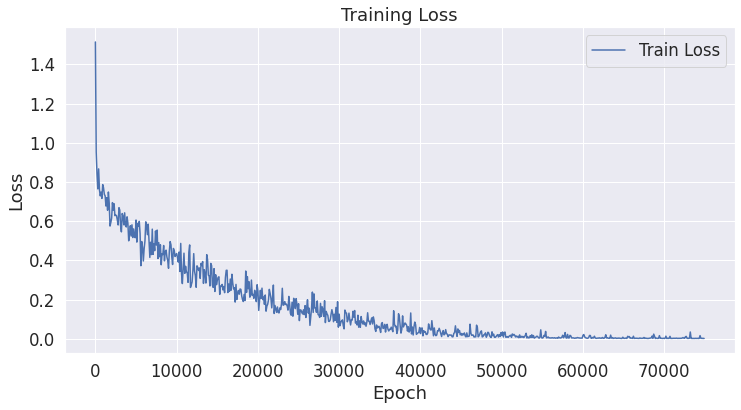

In [56]:
from  matplotlib.ticker import FuncFormatter
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.figure()
fig, ax = plt.subplots()
# this locator puts ticks at regular intervals
loc = ticker.MultipleLocator(base=0.2)
plt.plot(plot_losses1,label='Train Loss')

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

ax.yaxis.set_major_locator(loc)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: (int(x))*100))
#plt.plot(plot_losses1,label='Train Loss')


In [50]:
df_stats=pd.DataFrame(metrics1)
df_stats['BERTSCORE']=df_stats['BERTSCORE'].apply(lambda x: x.detach().numpy())
df_stats.rename(columns = {'iter':'epoch'}, inplace = True)
df_stats

,epoch,AVG_LOSS,BLEU,PPL,BERTSCORE
0,5000,0.668427,0.601697,1.951167,0.956768
1,10000,0.473756,0.709503,1.606015,0.967755
2,15000,0.348848,0.783126,1.417434,0.976527
3,20000,0.256658,0.837209,1.292603,0.982730
4,25000,0.181385,0.881739,1.198876,0.987364
5,30000,0.136082,0.906453,1.145775,0.990171
6,35000,0.089820,0.923816,1.093977,0.991909
7,40000,0.059761,0.948238,1.061583,0.994608
8,45000,0.033502,0.954403,1.034070,0.995026
9,50000,0.021325,0.955357,1.021554,0.995545


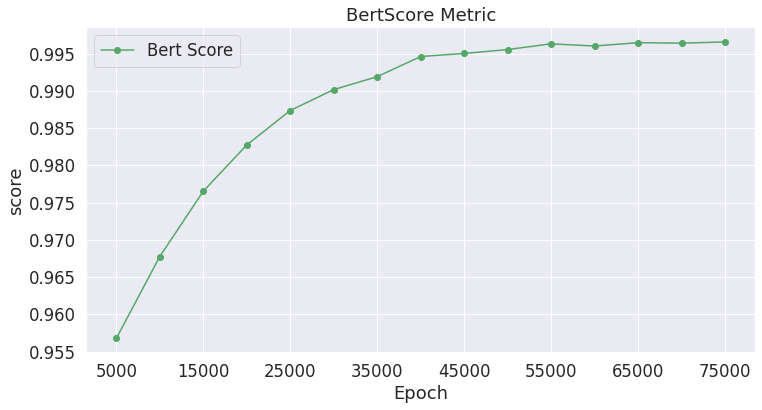

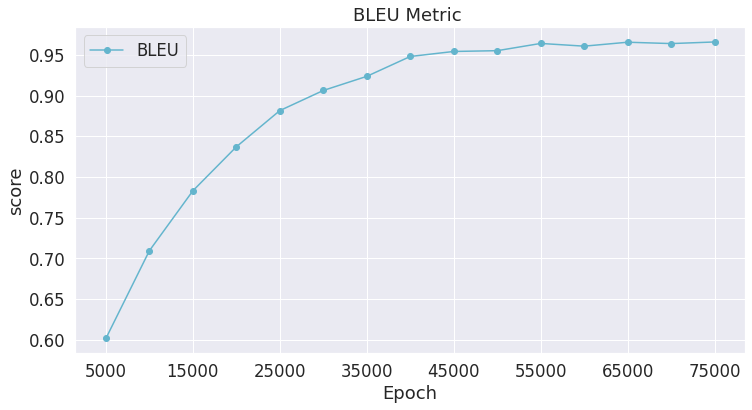

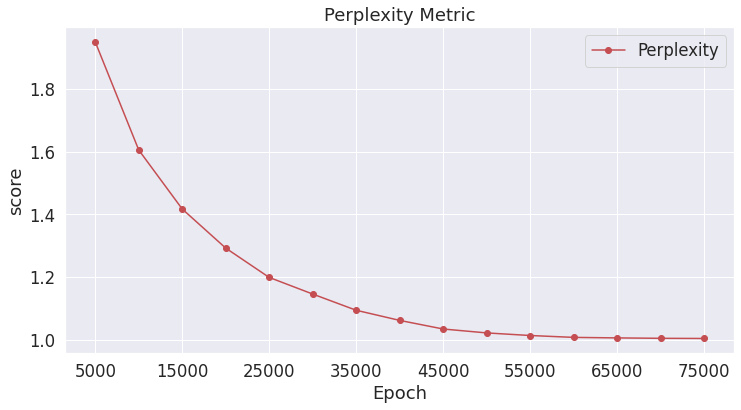

In [80]:
import seaborn as sns
from  matplotlib.ticker import FuncFormatter
titleAxisArr=['BertScore Metric','BLEU Metric ','Perplexity Metric']
labelsArr=['Bert Score','BLEU','Perplexity']
colorArr=['g-o','c-o','r-o']
plotTypeVar=['BERTSCORE','BLEU','PPL']
for i in range(len(plotTypeVar)):

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')
    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    # Plot the learning curve.
    #plt.plot(df_stats['AVG_LOSS'], 'b-o', label="Train Loss")
    #plt.plot(df_stats['BLEU'], 'g-o', label="BLEU")
    #plt.plot(df_stats['PPL'], 'r-o', label="Perplexity")
    #plt.plot(df_stats['BERTSCORE'], 'c-o', label="Bert Score")
    plt.plot(df_stats[plotTypeVar[i]], colorArr[i], label=labelsArr[i])


    # Label the plot.
    plt.title(titleAxisArr[i])
    plt.xlabel("Epoch")
    plt.ylabel("score")
    plt.legend()
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: (int(x)+1)*5000))
    plt.show()

In [84]:
##check the results
evaluateRandomly(encoder2, attn_decoder2)


> please fix space
= refactoring suggestion
< refactoring suggestion <EOS>

> please check for it s working and merge this pr .
= logistics suggestion
< logistics suggestion <EOS>

> also make the query re executable using insert ignore into
= buggycode suggestion
< buggycode suggestion <EOS>

> if the change is so regular can we add the field in database somewhere please discuss with the team and update .
= logical suggestion
< logical suggestion <EOS>

> why is company id being used here ?
= questioning
< questioning <EOS>

> from backend this will be a list non optional
= buggycode suggestion
< buggycode suggestion <EOS>

> controller gets only strings why are we using array ?
= buggycode suggestion
< buggycode suggestion <EOS>

> correct indentation 
= refactoring suggestion
< refactoring suggestion <EOS>

> please use the constant for . resolve the conflict also .
= logistics suggestion
< logistics suggestion <EOS>

> please check the function its list and its give only array of i

### code to visually see the attention while performing the translations ..in our case question should match to the right answer

cc-- here?
input = can we use !empty here?
output = code suggestion <EOS>


/home/gauravp/anaconda3/envs/rohitTransformer/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/gauravp/anaconda3/envs/rohitTransformer/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


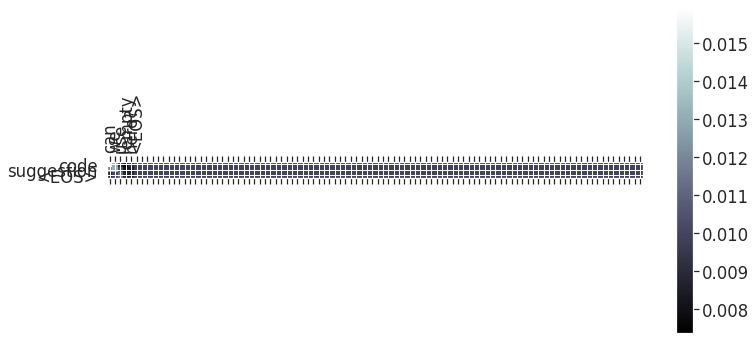

In [86]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder2, attn_decoder2, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("can we use !empty here?")

#evaluateAndShowAttention("what happened in 1838 ?")

